In [1]:
!pip install geopandas shapely

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import random

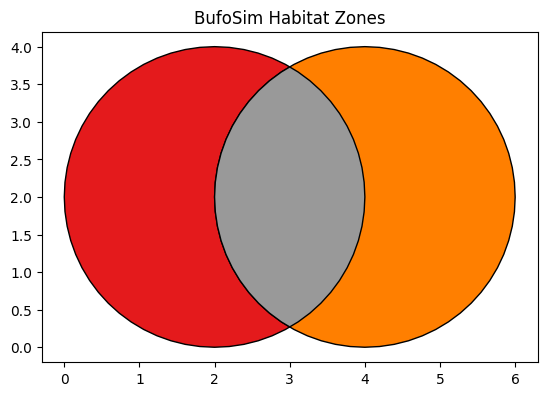

In [4]:

zone1 = Point(2, 2).buffer(2)
zone2 = Point(4, 2).buffer(2)
zone3 = zone1.intersection(zone2)

zones = gpd.GeoSeries([zone1, zone2, zone3])
zones.plot(edgecolor='black', cmap='Set1')
plt.title("BufoSim Habitat Zones")
plt.show()

In [7]:
def create_frog(id, species, zone_geom, zone_label):
    point = Point(np.random.uniform(zone_geom.bounds[0], zone_geom.bounds[2]),
                  np.random.uniform(zone_geom.bounds[1], zone_geom.bounds[3]))
    while not zone_geom.contains(point):
        point = Point(np.random.uniform(zone_geom.bounds[0], zone_geom.bounds[2]),
                      np.random.uniform(zone_geom.bounds[1], zone_geom.bounds[3]))
    return {
        "id": id,
        "species": species,
        "zone": zone_label,
        "geometry": point,
        "generation": 1,
        "genetic_resistance": round(np.random.uniform(0.4, 1.0), 2),
        "appetite": round(np.random.uniform(0.2, 0.8), 2),
        "aggression": round(np.random.uniform(0.1, 0.6), 2),
        "mobility": round(np.random.uniform(0.3, 0.9), 2),
        "alive": True,
        "mutated": False,
        "hybrid": True if species == "AB" else False
    }

frogs = []

# 40 toads of A in zone 1
for i in range(40):
    frogs.append(create_frog(i, "A", zone1, 1))

# 40 toads of B  in zone 2
for i in range(40, 80):
    frogs.append(create_frog(i, "B", zone2, 2))

# 20 AB hybrids in zone 3
for i in range(80, 100):
    frogs.append(create_frog(i, "AB", zone3, 3))

df = pd.DataFrame(frogs)
gdf = gpd.GeoDataFrame(df, geometry="geometry")

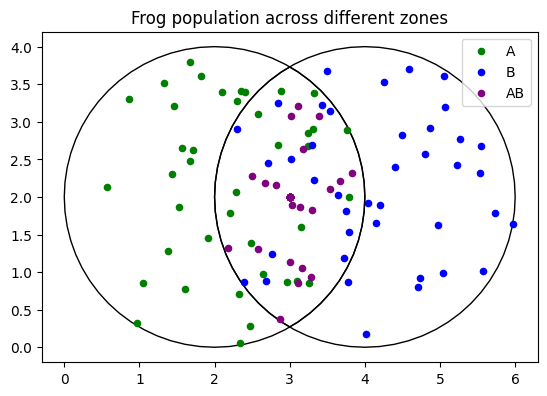

In [58]:
fig, ax = plt.subplots()
zones.plot(ax=ax, edgecolor='black', facecolor='none')
colors = {"A": "green", "B": "blue", "AB": "purple"}
for species in gdf["species"].unique():
    gdf[gdf["species"] == species].plot(ax=ax, markersize=20, color=colors[species], label=species)
plt.legend()
plt.title("Frog population across different zones")
plt.show()

In [36]:
def simulate_step(gdf, food_level=0.5, pollution_level=0.5, mutation_chance=0.1):
    new_data = []

    for i, row in gdf.iterrows():
        if not row["alive"]:
            new_data.append(row)
            continue

        #  death conditions
        hunger_death = row["appetite"] > food_level
        pollution_death = row["genetic_resistance"] < pollution_level

        died = hunger_death or pollution_death

        #  Mutation ( if not dead)
        mutated = False
        if not died and np.random.rand() < mutation_chance:
            row["genetic_resistance"] = min(1.0, max(0.0, row["genetic_resistance"] + np.random.normal(0, 0.05)))
            row["appetite"] = min(1.0, max(0.0, row["appetite"] + np.random.normal(0, 0.05)))
            row["aggression"] = min(1.0, max(0.0, row["aggression"] + np.random.normal(0, 0.05)))
            mutated = True

        # Migration( if not dead)
        if not died and np.random.rand() < row["mobility"]:
            if row["zone"] == 1:
                row["zone"] = 3 if zone3.contains(row["geometry"]) else 2
            elif row["zone"] == 2:
                row["zone"] = 3 if zone3.contains(row["geometry"]) else 1
            elif row["zone"] == 3:
                row["zone"] = random.choice([1, 2])

        row["mutated"] = mutated
        row["alive"] = False if died else True
        new_data.append(row)

    return gpd.GeoDataFrame(new_data, geometry="geometry")

In [11]:
gdf = simulate_step(gdf, food_level=0.4, pollution_level=0.6)

Alive individuals after step 1:
species
AB    29
B     11
A     10
Name: count, dtype: int64


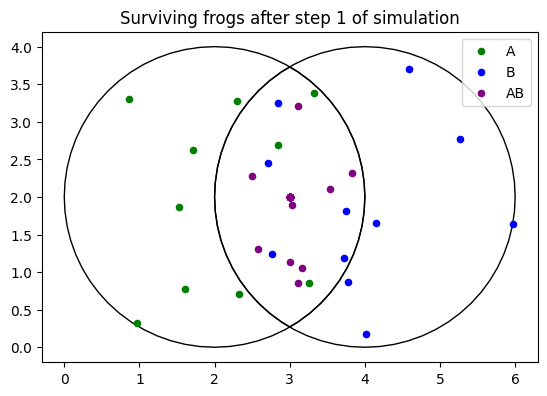

In [54]:

alive_counts = gdf[gdf["alive"] == True]["species"].value_counts()
print("Alive individuals after step 1:")
print(alive_counts)

fig, ax = plt.subplots()
zones.plot(ax=ax, edgecolor='black', facecolor='none')
for species in gdf["species"].unique():
    gdf[(gdf["species"] == species) & (gdf["alive"])].plot(
        ax=ax, markersize=20, color=colors[species], label=species)
plt.legend()
plt.title("Surviving frogs after step 1 of simulation")
plt.show()

In [38]:
def hybridize(gdf, next_id_start):
    new_frogs = []
    zone3_frogs = gdf[(gdf["zone"] == 3) & (gdf["alive"])]

    frogs_A = zone3_frogs[zone3_frogs["species"] == "A"]
    frogs_B = zone3_frogs[zone3_frogs["species"] == "B"]

    min_pairs = min(len(frogs_A), len(frogs_B))
    used_A = frogs_A.sample(min_pairs)
    used_B = frogs_B.sample(min_pairs)

    for i, (idx_a, row_a) in enumerate(used_A.iterrows()):
        row_b = used_B.iloc[i]

        new_frog = {
            "id": next_id_start + i,
            "species": "AB",
            "zone": 3,
            "geometry": zone3.centroid,
            "generation": max(row_a["generation"], row_b["generation"]) + 1,
            "genetic_resistance": round((row_a["genetic_resistance"] + row_b["genetic_resistance"]) / 2, 2),
            "appetite": round((row_a["appetite"] + row_b["appetite"]) / 2, 2),
            "aggression": round((row_a["aggression"] + row_b["aggression"]) / 2, 2),
            "mobility": round((row_a["mobility"] + row_b["mobility"]) / 2, 2),
            "alive": True,
            "mutated": False,
            "hybrid": True
        }

        new_frogs.append(new_frog)

    return pd.DataFrame(new_frogs)

In [39]:

next_id = gdf["id"].max() + 1

new_hybrids = hybridize(gdf, int(next_id))
if not new_hybrids.empty:
    gdf = pd.concat([gdf, gpd.GeoDataFrame(new_hybrids, geometry="geometry")], ignore_index=True)

=== Population Statistics ===

Species A:
   Total: 40
   Alive: 10
   Dead : 30

Species B:
   Total: 40
   Alive: 11
   Dead : 29

Species AB:
   Total: 40
   Alive: 29
   Dead : 11



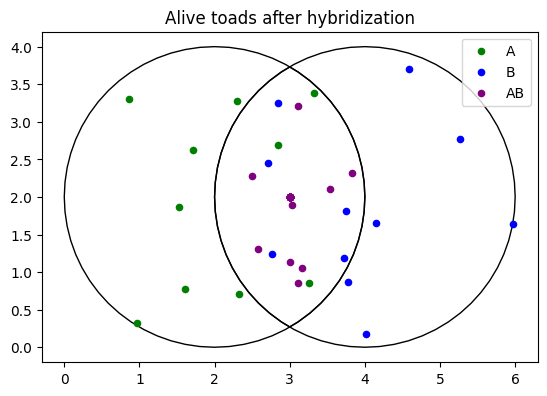

In [60]:
def print_population_stats(gdf):
    total = gdf.groupby("species")["id"].count()
    alive = gdf[gdf["alive"] == True].groupby("species")["id"].count()
    dead = gdf[gdf["alive"] == False].groupby("species")["id"].count()

    print("=== Population Statistics ===\n")
    for species in gdf["species"].unique():
        total_count = total.get(species, 0)
        alive_count = alive.get(species, 0)
        dead_count = dead.get(species, 0)
        print(f"Species {species}:")
        print(f"   Total: {total_count}")
        print(f"   Alive: {alive_count}")
        print(f"   Dead : {dead_count}")
        print()

print_population_stats(gdf)
fig, ax = plt.subplots()
zones.plot(ax=ax, edgecolor='black', facecolor='none')
for species in gdf["species"].unique():
    gdf[(gdf["species"] == species) & (gdf["alive"])].plot(
        ax=ax, markersize=20, color=colors[species], label=species)
plt.legend()
plt.title("Alive toads after hybridization")
plt.show()

In [22]:
history = []
steps = 10
next_id = gdf["id"].max() + 1

for step in range(steps):
    print(f"--- Simulation step {step+1} ---")


    gdf = simulate_step(gdf, food_level=0.4, pollution_level=0.6)


    new_hybrids = hybridize(gdf, int(next_id))
    if not new_hybrids.empty:
        gdf = pd.concat([gdf, gpd.GeoDataFrame(new_hybrids, geometry="geometry")], ignore_index=True)
        next_id = gdf["id"].max() + 1

    stats = gdf.groupby(["generation", "species"])["alive"].sum().reset_index()
    stats["step"] = step + 1
    history.append(stats)

--- Simulation step 1 ---
--- Simulation step 2 ---
--- Simulation step 3 ---
--- Simulation step 4 ---
--- Simulation step 5 ---
--- Simulation step 6 ---
--- Simulation step 7 ---
--- Simulation step 8 ---
--- Simulation step 9 ---
--- Simulation step 10 ---


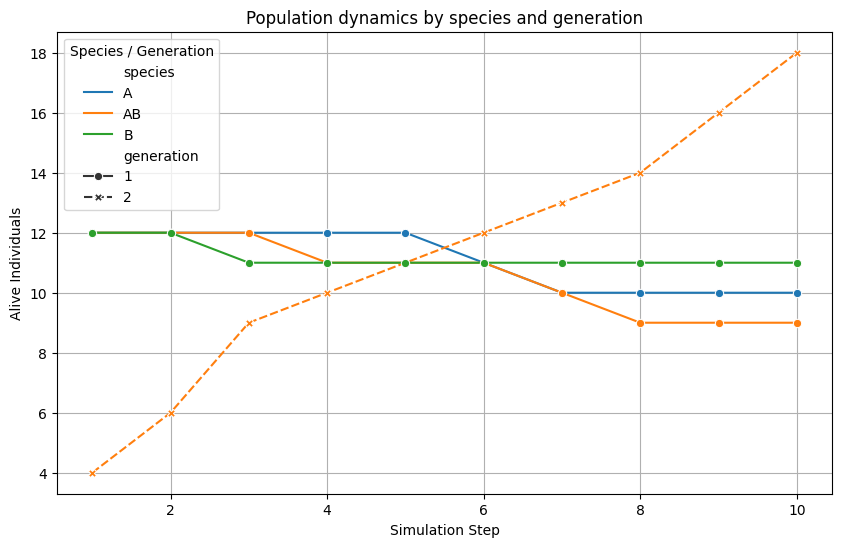

In [41]:
history_df = pd.concat(history, ignore_index=True)

import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(data=history_df, x="step", y="alive", hue="species", style="generation", markers=True)
plt.title("Population dynamics by species and generation")
plt.xlabel("Simulation Step")
plt.ylabel("Alive Individuals")
plt.grid(True)
plt.legend(title="Species / Generation")
plt.show()

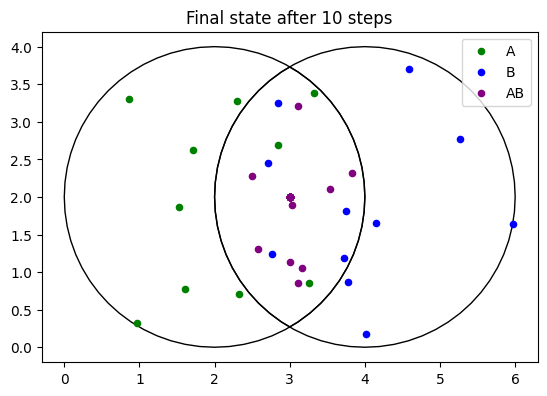

In [42]:
fig, ax = plt.subplots()
zones.plot(ax=ax, edgecolor='black', facecolor='none')
for species in gdf["species"].unique():
    gdf[(gdf["species"] == species) & (gdf["alive"])].plot(
        ax=ax, markersize=20, color=colors[species], label=species)
plt.legend()
plt.title(f"Final state after {steps} steps")
plt.show()

In [43]:
gdf.to_csv("BufoSim_final_population.csv", index=False)
print("Dataset saved as BufoSim_final_population.csv")

Dataset saved as BufoSim_final_population.csv


In [44]:
import os

folder = "bufo_frames"
os.makedirs(folder, exist_ok=True)

step_gdf = gdf.copy()

history_frames = []

step_gdf = gdf.copy()
step_gdf["alive"] = True
step_gdf["mutated"] = False

frame_id = 0
next_id = step_gdf["id"].max() + 1

for step in range(steps):
    step_gdf = simulate_step(step_gdf, food_level=0.4, pollution_level=0.6)

    new_hybrids = hybridize(step_gdf, int(next_id))
    if not new_hybrids.empty:
        step_gdf = pd.concat([step_gdf, gpd.GeoDataFrame(new_hybrids, geometry="geometry")], ignore_index=True)
        next_id = step_gdf["id"].max() + 1


    fig, ax = plt.subplots()
    zones.plot(ax=ax, edgecolor='black', facecolor='none')
    for species in step_gdf["species"].unique():
        step_gdf[(step_gdf["species"] == species) & (step_gdf["alive"])].plot(
            ax=ax, markersize=20, color=colors[species], label=species)
    plt.legend()
    plt.title(f"Step {step+1}")
    frame_path = f"{folder}/frame_{frame_id:02d}.png"
    plt.savefig(frame_path)
    plt.close()
    frame_id += 1

In [49]:
import imageio

images = []
for i in range(frame_id):
    filename = f"{folder}/frame_{i:02d}.png"
    images.append(imageio.imread(filename))

imageio.mimsave("bufo_evolution.gif", images, fps=1)
print("Saved animation: bufo_evolution.gif")

<ipython-input-49-18217c2875b7>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Saved animation: bufo_evolution.gif


In [52]:
from google.colab import files
files.download("bufo_evolution.gif")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
files.download("BufoSim_final_population.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>